In [1]:
import os
import torch
import torchvision
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as tt
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import cv2
from PIL import Image

## Preparing the Data

In [3]:
# Looking into the directory
data_dir = '../data/emotion'
print(os.listdir(data_dir))
classes_train = os.listdir(data_dir + "/train")
classes_valid = os.listdir(data_dir + "/val")
print(f'Train Classes - {classes_train}')
print(f'Validation Classes - {classes_valid}')

['train', 'fer2013.tar', 'fer2013.csv', 'val', 'tmp']
Train Classes - ['Neutral', 'Happy', 'Surprise', 'Sad', 'Angry']
Validation Classes - ['Neutral', 'Happy', 'Surprise', 'Sad', 'Angry']


In [4]:
# Data transforms (Gray Scaling & data augmentation)
train_tfms = tt.Compose([tt.Grayscale(num_output_channels=1),
                         tt.RandomHorizontalFlip(),
                         tt.RandomRotation(30),
                         tt.ToTensor()])

valid_tfms = tt.Compose([tt.Grayscale(num_output_channels=1), tt.ToTensor()])

In [5]:
# Emotion Detection datasets
train_ds = ImageFolder(data_dir + '/train', train_tfms)
valid_ds = ImageFolder(data_dir + '/val', valid_tfms)

In [6]:
batch_size = 200

In [7]:
# PyTorch data loaders
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
valid_dl = DataLoader(valid_ds, batch_size*2, num_workers=4, pin_memory=True)

In [8]:
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        print(images[0].shape)
        ax.imshow(make_grid(images[:64], nrow=8).permute(1, 2, 0))
        break

torch.Size([1, 48, 48])


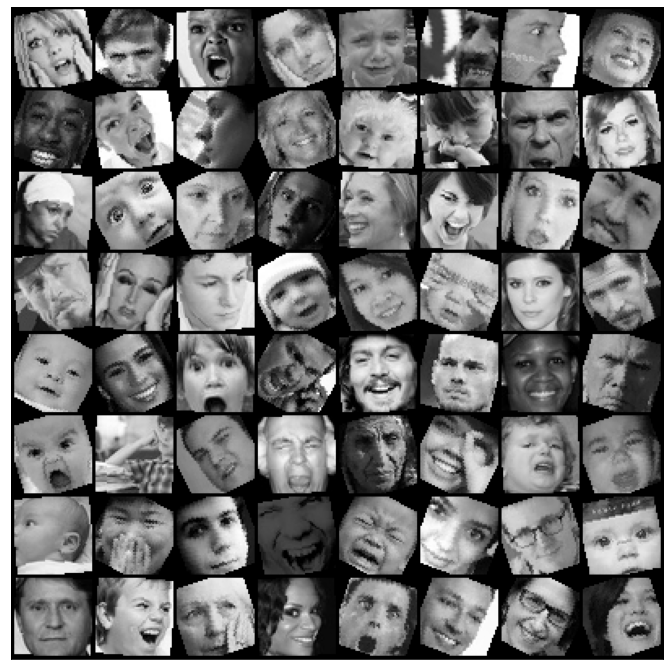

In [9]:
show_batch(train_dl)

## Using a GPU

Tranfering the model and data to the 'cuda', if available

In [10]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        return len(self.dl)

In [11]:
device = get_default_device()
device

device(type='cuda')

In [12]:
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

## Training Steps Creation

In [13]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)
        loss = F.cross_entropy(out, labels)
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)
        loss = F.cross_entropy(out, labels)
        acc = accuracy(out, labels)
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))

## Model Creation

In [14]:
# def conv_block(in_channels, out_channels, pool=False):
#     layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
#               nn.BatchNorm2d(out_channels), 
#               nn.ELU(inplace=True)]
#     if pool: layers.append(nn.MaxPool2d(2))
#     return nn.Sequential(*layers)

# class ResNet(ImageClassificationBase):
#     def __init__(self, in_channels, num_classes):
#         super().__init__()
        
#         self.conv1 = conv_block(in_channels, 128)
#         self.conv2 = conv_block(128, 128, pool=True)
#         self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))
#         self.drop1 = nn.Dropout(0.5)
        
#         self.conv3 = conv_block(128, 256)
#         self.conv4 = conv_block(256, 256, pool=True)
#         self.res2 = nn.Sequential(conv_block(256, 256), conv_block(256, 256))
#         self.drop2 = nn.Dropout(0.5)
        
#         self.conv5 = conv_block(256, 512)
#         self.conv6 = conv_block(512, 512, pool=True)
#         self.res3 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))
#         self.drop3 = nn.Dropout(0.5)
        
#         self.classifier = nn.Sequential(nn.MaxPool2d(6), 
#                                         nn.Flatten(),
#                                         nn.Linear(512, num_classes))
        
#     def forward(self, xb):
#         out = self.conv1(xb)
#         out = self.conv2(out)
#         out = self.res1(out) + out
#         out = self.drop1(out)
        
#         out = self.conv3(out)
#         out = self.conv4(out)
#         out = self.res2(out) + out
#         out = self.drop2(out)
        
#         out = self.conv5(out)
#         out = self.conv6(out)
#         out = self.res3(out) + out
#         out = self.drop3(out)
        
#         out = self.classifier(out)
#         return out
    

class ResNet(ImageClassificationBase):
  def __init__(self):
    super(ResNet, self).__init__()
    self.cnn1 = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3)
    self.cnn2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3)
    self.cnn3 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3)
    self.cnn4 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)
    self.cnn5 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3)
    self.cnn6 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3)
    self.cnn7 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3)
    self.relu = nn.ReLU()
    self.pool1 = nn.MaxPool2d(2, 1)
    self.pool2 = nn.MaxPool2d(2, 2)
    self.cnn1_bn = nn.BatchNorm2d(8)
    self.cnn2_bn = nn.BatchNorm2d(16)
    self.cnn3_bn = nn.BatchNorm2d(32)
    self.cnn4_bn = nn.BatchNorm2d(64)
    self.cnn5_bn = nn.BatchNorm2d(128)
    self.cnn6_bn = nn.BatchNorm2d(256)
    self.cnn7_bn = nn.BatchNorm2d(256)
    self.fc1 = nn.Linear(1024, 512)
    self.fc2 = nn.Linear(512, 256)
    self.fc3 = nn.Linear(256, 7)
    self.dropout = nn.Dropout(0.3)
    self.log_softmax = nn.LogSoftmax(dim=1)

  def forward(self, x):
    x = self.relu(self.pool1(self.cnn1_bn(self.cnn1(x))))
    x = self.relu(self.pool1(self.cnn2_bn(self.dropout(self.cnn2(x)))))
    x = self.relu(self.pool1(self.cnn3_bn(self.cnn3(x))))
    x = self.relu(self.pool1(self.cnn4_bn(self.dropout(self.cnn4(x)))))
    x = self.relu(self.pool2(self.cnn5_bn(self.cnn5(x))))
    x = self.relu(self.pool2(self.cnn6_bn(self.dropout(self.cnn6(x)))))
    x = self.relu(self.pool2(self.cnn7_bn(self.dropout(self.cnn7(x)))))

    x = x.view(x.size(0), -1)

    x = self.relu(self.dropout(self.fc1(x)))
    x = self.relu(self.dropout(self.fc2(x)))
    x = self.log_softmax(self.fc3(x))
    return x

  def count_parameters(self):
    return sum(p.numel() for p in self.parameters() if p.requires_grad)

  def training_step(self, batch):
    images, labels = batch 
    out = self(images)
    loss = F.cross_entropy(out, labels)
    return loss
    
  def validation_step(self, batch):
    images, labels = batch 
    out = self(images)
    loss = F.cross_entropy(out, labels)
    acc = accuracy(out, labels)
    return {'val_loss': loss.detach(), 'val_acc': acc}

  def validation_epoch_end(self, outputs):
    batch_losses = [x['val_loss'] for x in outputs]
    epoch_loss = torch.stack(batch_losses).mean()
    batch_accs = [x['val_acc'] for x in outputs]
    epoch_acc = torch.stack(batch_accs).mean()
    return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

  def epoch_end(self, epoch, result):
    print("Epoch [{}], last_lr: {:.6f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
    epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))    

In [15]:
model = to_device(ResNet(), device)
model

ResNet(
  (cnn1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1))
  (cnn2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
  (cnn3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (cnn4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (cnn5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (cnn6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (cnn7): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
  (relu): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cnn1_bn): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (cnn2_bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (cnn3_bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (cnn4_bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (cnn5_bn

## Training the model


In [16]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, 
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    
    # Set up custom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_loader))
    
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            # Gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()
        
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [17]:
history = [evaluate(model, valid_dl)]
history

/opt/conda/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ../c10/core/TensorImpl.h:1153.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


[{'val_loss': 1.942879319190979, 'val_acc': 0.19562500715255737}]

In [18]:
epochs = 90
max_lr = 0.008
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [19]:
%%time
history += fit_one_cycle(epochs, max_lr, model, train_dl, valid_dl, 
                        grad_clip=grad_clip, weight_decay=weight_decay, opt_func=opt_func)

Epoch [0], last_lr: 0.000346, train_loss: 1.5199, val_loss: 1.4708, val_acc: 0.3830
Epoch [1], last_lr: 0.000423, train_loss: 1.3186, val_loss: 1.3572, val_acc: 0.4486
Epoch [2], last_lr: 0.000550, train_loss: 1.2179, val_loss: 1.2636, val_acc: 0.4878
Epoch [3], last_lr: 0.000727, train_loss: 1.1605, val_loss: 1.2810, val_acc: 0.4858
Epoch [4], last_lr: 0.000950, train_loss: 1.1227, val_loss: 1.2813, val_acc: 0.4843
Epoch [5], last_lr: 0.001217, train_loss: 1.1046, val_loss: 1.2407, val_acc: 0.5185
Epoch [6], last_lr: 0.001523, train_loss: 1.0837, val_loss: 1.2120, val_acc: 0.5223
Epoch [7], last_lr: 0.001865, train_loss: 1.0712, val_loss: 1.2130, val_acc: 0.5403
Epoch [8], last_lr: 0.002238, train_loss: 1.0566, val_loss: 1.2799, val_acc: 0.4919
Epoch [9], last_lr: 0.002637, train_loss: 1.0429, val_loss: 1.2079, val_acc: 0.5331
Epoch [10], last_lr: 0.003057, train_loss: 1.0463, val_loss: 1.2385, val_acc: 0.4765
Epoch [11], last_lr: 0.003491, train_loss: 1.0437, val_loss: 1.1845, val_ac

## Plotting Performance Graphs of the Model

In [20]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

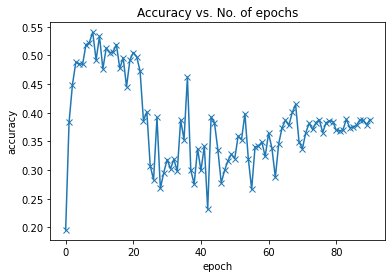

In [21]:
plot_accuracies(history)

In [22]:
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');

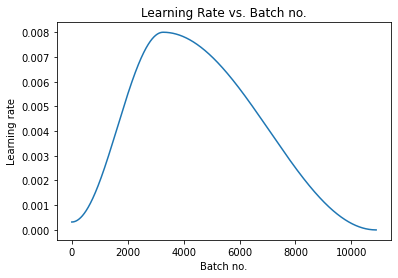

In [23]:
plot_lrs(history)

## Saving the Model



In [26]:
torch.save(model.state_dict(), '../models/emotion_m2tr-0723_90e_.35.pth')

In [27]:
def load_trained_model1(model_path):
    model = to_device(ResNet(), device)
    #model = to_device(ResNet(1, len(classes_train)), device)
    model.load_state_dict(torch.load(model_path, map_location=lambda storage, loc: storage), strict=False)
    return model

In [30]:
def FER_image1(img_path):

    model = load_trained_model1('../models/emotion_m2tr-0723_90e_.35.pth')
    
    emotion_dict = classes_train
    
    val_transform = tt.Compose([
        tt.ToTensor()])


    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    face_cascade = cv2.CascadeClassifier('../models/haarcascade_frontalface_default.xml')
    faces = face_cascade.detectMultiScale(img)
    for (x, y, w, h) in faces:
        cv2.rectangle(img, (x,y), (x+w, y+h), (255,0,0), 2)
        resize_frame = cv2.resize(gray[y:y + h, x:x + w], (48, 48))
        X = resize_frame/256
        X = Image.fromarray((resize_frame))
        X = val_transform(X).unsqueeze(0)
        with torch.no_grad():
            model.eval()
            log_ps = model.cpu()(X)
            ps = torch.exp(log_ps)
            top_p, top_class = ps.topk(1, dim=1)
            pred = emotion_dict[int(top_class.numpy())]
        cv2.putText(img, pred, (x, y), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0), 1)

    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.grid(False)
    plt.axis('off')
    plt.show()

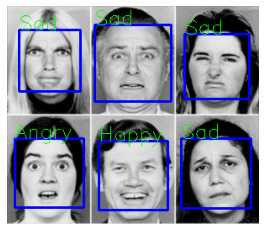

In [32]:
FER_image1('../data/test_images/test.jpg')